# Baseline model testing in "Subject-wise data"

-EEGNet, EEGConformer

.
├── masks
│   ├── mask_{num:0-49}.npy
├── normalized_timeseries
│   ├── fixation_denormed_timeseries_data.npy
│   ├── fixation_normalized_timeseries_data.npy
│   ├── whole_trial_denormed_timeseries_data.npy
│   └── whole_trial_normalized_timeseries_data.npy
├── raw_timeseries_data.npy
├── raw_timeseries_label.npy
└── stft
    ├── base_stft_timeseries_data-f.npy
    ├── base_stft_timeseries_data-t.npy
    ├── base_stft_timeseries_data-Zxx.npy
    ├── halfnfft_stft_timeseries_data-f.npy
    ├── halfnfft_stft_timeseries_data-t.npy
    ├── halfnfft_stft_timeseries_data-Zxx.npy
    ├── halfoverlap_halfnfft_stft_timeseries_data-f.npy
    ├── halfoverlap_halfnfft_stft_timeseries_data-t.npy
    ├── halfoverlap_halfnfft_stft_timeseries_data-Zxx.npy
    ├── halfoverlap_stft_timeseries_data-f.npy
    ├── halfoverlap_stft_timeseries_data-t.npy
    ├── halfoverlap_stft_timeseries_data-Zxx.npy
    ├── nooverlap_halfnfft_stft_timeseries_data-f.npy
    ├── nooverlap_halfnfft_stft_timeseries_data-t.npy
    ├── nooverlap_halfnfft_stft_timeseries_data-Zxx.npy
    ├── nooverlap_stft_timeseries_data-f.npy
    ├── nooverlap_stft_timeseries_data-t.npy
    └── nooverlap_stft_timeseries_data-Zxx.npy

    stft 
    (base/halfnfft/halfoverlap/nooverlap)
    (stft/halfnfft/)
    (f/t/Zxx) : [row] frequencies([0, Nyquist freq]) / [column] Times / [2d matrix] STFT Matrix


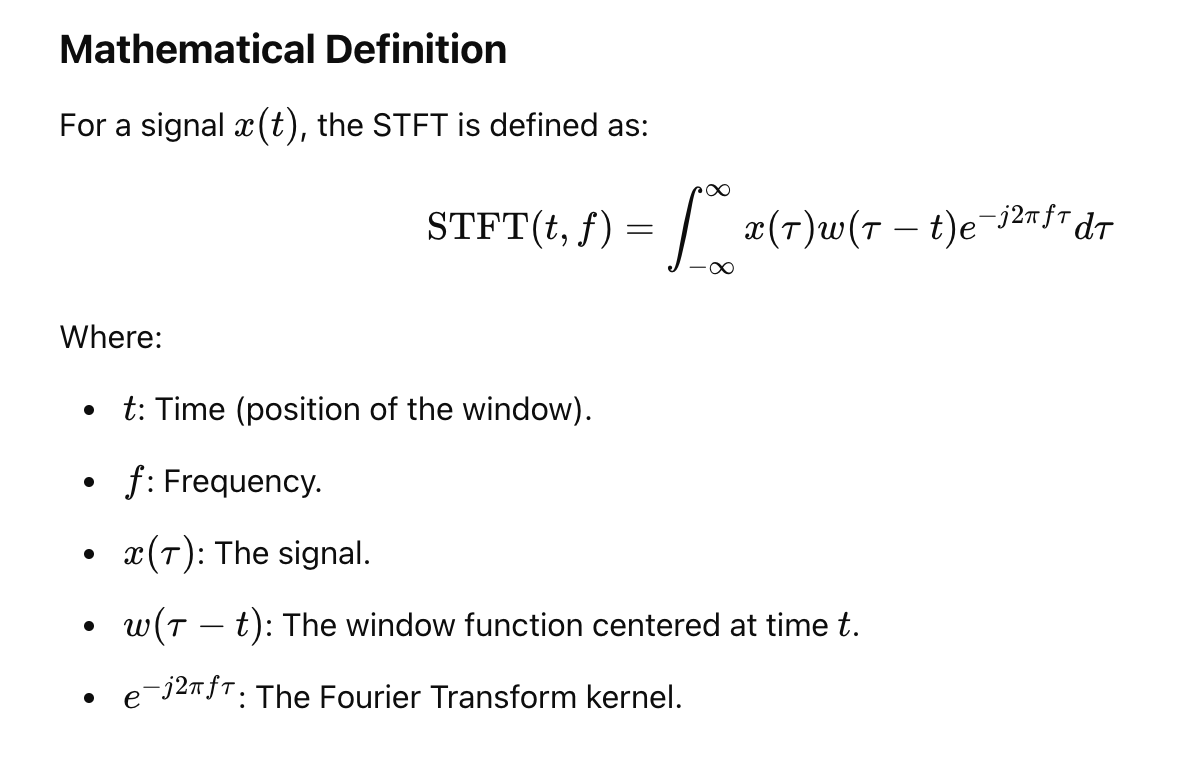

# EXPLORE

In [1]:
dataset_path="/scratch/connectome/dyhan316/ECOG_PILOT/data_rearranged/subject-wise"
import os

directories = os.listdir(dataset_path)
print(directories)

['stft', 'raw_timeseries_label.npy', 'raw_timeseries_data.npy', 'normalized_timeseries', 'masks']


In [3]:
import numpy as np

stft_path = os.path.join(dataset_path, 'stft')
base_stft_f = np.load(os.path.join(stft_path, 'base_stft_timeseries_data-f.npy'))
base_stft_t = np.load(os.path.join(stft_path, 'base_stft_timeseries_data-t.npy'))
base_stft_Zxx = np.load(os.path.join(stft_path, 'base_stft_timeseries_data-Zxx.npy'))

print(base_stft_f.shape, base_stft_t.shape, base_stft_Zxx.shape)

(150,) (501,) (3, 120, 150, 501)


In [5]:
mask_path = os.path.join(dataset_path, 'masks/mask_0.npy')
mask = np.load(mask_path)
print(mask.shape)

(3, 120)


In [9]:
label_path=os.path.join(dataset_path, 'raw_timeseries_label.npy')
labels=np.load(label_path)
print(labels.shape)

(3, 120)


# Define Dataset

In [10]:
import torch
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils
import pandas as pd

class MyDataset(Dataset):
    def __init__(self, root_dir, data, label, transform=None):
        self.root_dir = root_dir
        self.data = np.load(os.path.join(root_dir, data))
        self.label = np.load(os.path.join(root_dir, label))
        self.transform = transform
        
    def init_io(self):
        self.info = pd.DataFrame({
                "subject_id": [1],
                "trial_id": [1],
                "duration": [10000],
                "_record_id": ["_record_0"]
            })
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample_data = torch.tensor(self.data[idx], dtype=torch.float32)  # Ensure data is float32
        sample_label = torch.tensor(self.label[idx], dtype=torch.float32)  # Ensure label is float32
        
        if self.transform:
            sample_data = self.transform(sample_data)
        
        return sample_data, sample_label



In [13]:
#from torch import float32
from torchvision import transforms

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.to(torch.float32))  # Ensure data is float32
])

dataset = MyDataset(dataset_path, 'stft/base_stft_timeseries_data-Zxx.npy', 'raw_timeseries_label.npy', transform=transform)
dataset.init_io()

In [14]:
data_tensor, label_tensor = dataset[0]
print(f"Data tensor type: {data_tensor.dtype}") #should be float32 
print(f"Label tensor type: {label_tensor.dtype}")

Data tensor type: torch.float32
Label tensor type: torch.float32


In [26]:
print(f"Data tensor shape: {data_tensor.shape}") #(label_num, freq, timepoints)
print(len(dataset))

Data tensor shape: torch.Size([120, 150, 501])
3


In [30]:
data = torch.stack([d[0] for d in dataset])
data.shape

torch.Size([3, 120, 150, 501])

# Train test split using mask

In [19]:
from torch.utils.data import Subset

mask_path=os.path.join(dataset_path, 'masks/mask_0.npy')
mask = np.load(mask_path)

# Create train and test indices based on the mask
train_indices = np.where(mask == 0)[0]
test_indices = np.where(mask == 1)[0]

def collate_fn(batch):
    data, label = zip(*batch)
    data = torch.stack([torch.tensor(d, dtype=torch.float32) for d in data]).unsqueeze(1)  # Add electrode dimension
    label = torch.stack([torch.tensor(l, dtype=torch.long) for l in label])
    return data, label


# Create train and test subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the sizes of the train and test sets
print(f"Train set size: {len(train_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Train set size: 252
Test set size: 108


In [21]:
from torcheeg.models import EEGNet

model = EEGNet(chunk_size=120,
               num_electrodes=1,
               dropout=0.5,
               kernel_1=64,
               kernel_2=16,
               F1=8,
               F2=16,
               D=2,
               num_classes=2)
x, y = next(iter(train_loader))
model(x)

RuntimeError: Given groups=1, weight of size [8, 1, 1, 64], expected input[32, 120, 150, 501] to have 1 channels, but got 120 channels instead

In [ ]:
from torcheeg.models import EEGNet

model = EEGNet(chunk_size=2500,
               num_electrodes=1,
               dropout=0.5,
               kernel_1=64,
               kernel_2=16,
               F1=8,
               F2=16,
               D=2,
               num_classes=2)
x, y = next(iter(train_loader))
model(x)